In [1]:
from transformers import AdamW, T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments, get_scheduler
from datasets import load_dataset, load_metric
import datasets
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import gc
from tqdm.auto import tqdm
import random
from copy import deepcopy
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [3]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)

In [4]:
torch.cuda.memory_allocated(device=device)

242026496

In [5]:
squad_raw = load_dataset('squad')
def preprocess_squad(examples):
    return {'id': examples['id'],
            'src':
                ['question: ' + question + ' context: ' + context
                 for question, context in zip(examples['question'], examples['context'])
                ],
            'trg': [answer['text'][0] for answer in examples['answers']],
            'answers': examples['answers']
           }
squad = squad_raw.map(preprocess_squad, batched=True, remove_columns=squad_raw['train'].column_names)

Reusing dataset squad (C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-ecd5ee8576e1cf08.arrow
Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-3365be9634cfe8c0.arrow


In [6]:
squad_metric = load_metric("squad")

In [7]:
def eval_squad(model, n):
    progress_bar = tqdm(range(n))
    shuffled = squad['validation'].shuffle()
    model.eval()
    b_size = 8
    start = 0
    end = b_size
    exists = True
    model.eval()
    while exists:
        examples = shuffled[start: end]
        input_ids = tokenizer(examples['src'], return_tensors="pt", padding=True).input_ids.to(device)
        with torch.no_grad():
            outputs = model.generate(input_ids=input_ids)

        decoded = [{'id': ide, 'prediction_text': tokenizer.decode(outputs[i], skip_special_tokens=True)} for i, ide in zip(range(len(examples['id'])), examples['id'])]
        refs = [{'id': examples['id'][i], 'answers': ans} for i, ans in enumerate(examples['answers'])]
        squad_metric.add_batch(predictions=decoded, references=refs)
        progress_bar.update(len(examples['id']))
        start = end
        end = end + b_size
        del input_ids
        del outputs
        if end > n:
            break

    return squad_metric.compute()

In [8]:
mnli_raw = load_dataset('glue', 'mnli')
mnli_i2w = {1: 'neutral', 0: 'entailment', 2: 'contradiction'}
mnli_w2i = defaultdict(lambda: -1)
for k, v in mnli_i2w.items():
    mnli_w2i[v] = k
    
def preprocess_mnli(examples):
    return {
            'src':
                ['mnli hypothesis: ' + hypothesis + ' premise: ' + premise
                 for hypothesis, premise in zip(examples['hypothesis'], examples['premise'])
                ],
            'trg': [mnli_i2w[label] for label in examples['label']],
            'label': examples['label']
           }

mnli = mnli_raw.filter(lambda example: example['label']!=-1)
mnli = mnli.map(preprocess_mnli, batched=True, remove_columns=mnli_raw['test_matched'].column_names)

Reusing dataset glue (C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-e64beea803f99dd4.arrow
Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-7ef27216f2d96777.arrow
Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-0602151f1c07f844.arrow
Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-668a5ec0a2da5560.arrow
Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-22fe2fe23baa4c74.arrow
Loading cached processed dataset at C:\Users\Prana

In [9]:
mnli_metric = load_metric('glue', 'mnli')

In [10]:
def eval_mnli(model, n, matched=True):
    progress_bar = tqdm(range(n))
    model.eval()
    shuffled = mnli['validation_matched'].shuffle() if matched else mnli['validation_mismatched'].shuffle()
    b_size = 8
    start = 0
    end = b_size
    model.eval()
    while True:
        examples = shuffled[start: end]
        input_ids = tokenizer(examples['src'], return_tensors="pt", padding=True).input_ids.to(device)
        with torch.no_grad():
            outputs = model.generate(input_ids=input_ids)

        outs = [mnli_w2i[w] for w in tokenizer.batch_decode(outputs, skip_special_tokens=True)]
        mnli_metric.add_batch(predictions=outs, references=examples['label'])
        progress_bar.update(len(examples['src']))
        start = end
        end = end + b_size
        del input_ids
        del outputs
        if end > n:
            break

    return mnli_metric.compute()

In [11]:
paws_raw = load_dataset('paws', 'labeled_final')
def preprocess_paws(examples):
    return {
        'sentence1': ['paraphrase: ' + example for example in examples['sentence1']] + ['paraphrase: ' + example for example in examples['sentence2']],
        'sentence2': [example for example in examples['sentence2']] + [example for example in examples['sentence1']]
    }
paws = paws_raw.filter(lambda example: example['label'] == 1)
paws = paws.map(preprocess_paws, batched=True, remove_columns=paws_raw['train'].column_names)

Reusing dataset paws (C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34)


Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-f8f4b05c63816056.arrow
Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-9bfc9aaee2aa1e33.arrow
Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-274702c64a43f78c.arrow
Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-8cfc468b57bda0be.arrow
Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-9f16df949f420df8.arrow
Loadi

In [12]:
qqp_raw = load_dataset('quora')
def preprocess_qqp(examples):
    return {
        'sentence1': ['paraphrase: ' + example['text'][0] for example in examples['questions']] + ['paraphrase: ' + example['text'][1] for example in examples['questions']],
        'sentence2': [example['text'][1] for example in examples['questions']] + [example['text'][0] for example in examples['questions']]
    }
qqp = qqp_raw.filter(lambda example: example['is_duplicate'] == True)
qqp = qqp.map(preprocess_qqp, batched=True, remove_columns=qqp_raw['train'].column_names)
qqp = qqp['train'].train_test_split(0.2)

Using custom data configuration default
Reusing dataset quora (C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04)


Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-af099628d2f3eec5.arrow
Loading cached processed dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-d96aef4cdf8b017c.arrow
Loading cached split indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-65a21446bcb6312e.arrow and C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-e006783d3c4b7ff9.arrow


In [13]:
paws_loader = DataLoader(paws['train'], shuffle=True, batch_size=8)
qqp_loader = DataLoader(qqp['train'], shuffle=True, batch_size=8)

In [14]:
bleu = load_metric("bleu")

In [15]:
def eval_ppg(model, n, on='paws'):
    progress_bar = tqdm(range(n))
    model.eval()
    shuffled = paws['test'].shuffle() if on == 'paws' else qqp['test'].shuffle()
    b_size = 8
    start = 0
    end = b_size
    model.eval()
    while True:
        examples = shuffled[start: end]
        input_ids = tokenizer(examples['sentence1'], return_tensors="pt", padding=True).input_ids.to(device)
        with torch.no_grad():
            outputs = model.generate(input_ids=input_ids)

        predictions = [s.split(" ") for s in tokenizer.batch_decode(outputs, skip_special_tokens=True)]
        references = [[s.split(" ")] for s in examples['sentence2']]
        bleu.add_batch(predictions=predictions, references=references)
        progress_bar.update(len(examples['sentence1']))
        start = end
        end = end + b_size
        del input_ids
        del outputs
        if end > n:
            break

    return bleu.compute()

In [16]:
optimizer = AdamW(model.parameters(), lr=3e-4)
num_epochs = 3
num_training_steps_paws = num_epochs * len(paws_loader)
num_training_steps_qqp = num_epochs * len(qqp_loader)
lr_scheduler_paws = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps_paws
)
lr_scheduler_qqp = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps_qqp
)

In [17]:
normal_history = {'squad': [], 'mnli': [], 'paws': [], 'qqp': []}

In [18]:
%load_ext line_profiler
def train(on='paws'):
    progress_bar = tqdm(range(num_training_steps_paws)) if on=='paws' else tqdm(range(num_training_steps_qqp))
    loader = paws_loader if on == 'paws' else qqp_loader
    i = 0
    convergence = False
    prev_bleu = 100
    model.train()
    for epoch in range(num_epochs):
        for batch in loader:
            
            if i%500 == 0:
                s = eval_squad(model, 128)
                m = eval_mnli(model, 128)
                p = eval_ppg(model, 128, 'paws')
                q = eval_ppg(model, 128, 'qqp')
                print(s, m, p, q)
                normal_history['squad'].append({'iter': i, 'metrics': s})
                normal_history['mnli'].append({'iter': i, 'metrics': m})
                normal_history['paws'].append({'iter': i, 'metrics': p})
                normal_history['qqp'].append({'iter': i, 'metrics': q})
                model.save_pretrained("checkpoints/standard/" + str(i))
                
                if on == 'paws':
                    if(abs(p['bleu'] - prev_bleu) < 2e-3):
                        convergence = True
                        print('Convergence reached.')
                        break
                    prev_bleu = p['bleu']
                else:
                    if(abs(q['bleu'] - prev_bleu) < 2e-3):
                        convergence = True
                        print('Convergence reached.')
                        break
                    prev_bleu = q['bleu']
                    
                model.train()
                
            input_ids = tokenizer(batch['sentence1'], return_tensors="pt", padding=True).input_ids.to(device)
            labels = tokenizer(batch['sentence2'], return_tensors="pt", padding=True).input_ids.to(device)
            outputs = model(input_ids=input_ids, labels=labels)
            outputs.loss.backward()
            optimizer.step()
            if on == 'paws':
                lr_scheduler_paws.step()
            else:
                lr_scheduler_qqp.step()                
            optimizer.zero_grad()
            del input_ids
            del labels
            del outputs
            i = i + 1
            progress_bar.update(1)
            
        if convergence:
            break

In [19]:
%lprun -f train train()

Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


{'exact_match': 76.5625, 'f1': 84.84990397674223} {'accuracy': 0.7890625} {'bleu': 0.003713526202373805, 'precisions': [0.5900900900900901, 0.569620253164557, 0.4355400696864111, 0.32945736434108525], 'brevity_penalty': 0.007924168880528161, 'length_ratio': 0.1712962962962963, 'translation_length': 444, 'reference_length': 2592} {'bleu': 0.03005037837237978, 'precisions': [0.38392857142857145, 0.21875, 0.10144927536231885, 0.04741379310344827], 'brevity_penalty': 0.21196390341569352, 'length_ratio': 0.39195100612423445, 'translation_length': 448, 'reference_length': 1143}




Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow




{'exact_match': 64.0625, 'f1': 76.79531434753358} {'accuracy': 0.828125} {'bleu': 0.30086852539528913, 'precisions': [0.8334373050530256, 0.6338983050847458, 0.48700816629547145, 0.3757178014766202], 'brevity_penalty': 0.5395778606633652, 'length_ratio': 0.6184413580246914, 'translation_length': 1603, 'reference_length': 2592} {'bleu': 0.2500356306258007, 'precisions': [0.5618279569892473, 0.3319838056680162, 0.20116279069767443, 0.11475409836065574], 'brevity_penalty': 0.9760967695185692, 'length_ratio': 0.9763779527559056, 'translation_length': 1116, 'reference_length': 1143}


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 50.78125, 'f1': 64.0159967687541} {'accuracy': 0.828125} {'bleu': 0.30320357306963003, 'precisions': [0.8283076923076923, 0.6259185036740147, 0.4784514243973703, 0.3682514101531023], 'brevity_penalty': 0.5515201396099477, 'length_ratio': 0.626929012345679, 'translation_length': 1625, 'reference_length': 2592} {'bleu': 0.24165333331023112, 'precisions': [0.5661896243291592, 0.3323232323232323, 0.191415313225058, 0.10354223433242507], 'brevity_penalty': 0.9778868024418416, 'length_ratio': 0.9781277340332458, 'translation_length': 1118, 'reference_length': 1143}


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 37.5, 'f1': 52.43284110701387} {'accuracy': 0.8125} {'bleu': 0.30344451168016784, 'precisions': [0.8335380835380836, 0.6273333333333333, 0.47667638483965014, 0.3633440514469453], 'brevity_penalty': 0.5531436246309793, 'length_ratio': 0.6280864197530864, 'translation_length': 1628, 'reference_length': 2592} {'bleu': 0.2507981237229819, 'precisions': [0.5617173524150268, 0.33535353535353535, 0.20069605568445475, 0.11444141689373297], 'brevity_penalty': 0.9778868024418416, 'length_ratio': 0.9781277340332458, 'translation_length': 1118, 'reference_length': 1143}
Convergence reached.


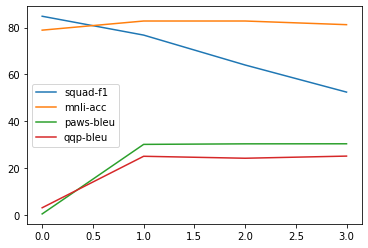

In [20]:
plt.plot([entry['metrics']['f1'] for entry in normal_history['squad']], label='squad-f1')
plt.plot([entry['metrics']['accuracy'] * 100 for entry in normal_history['mnli']], label='mnli-acc')
plt.plot([entry['metrics']['bleu'] * 100 for entry in normal_history['paws']], label='paws-bleu')
plt.plot([entry['metrics']['bleu'] * 100 for entry in normal_history['qqp']], label='qqp-bleu')
plt.legend()

In [21]:
train('qqp')

Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 37.5, 'f1': 52.43284110701387} {'accuracy': 0.8125} {'bleu': 0.30344451168016784, 'precisions': [0.8335380835380836, 0.6273333333333333, 0.47667638483965014, 0.3633440514469453], 'brevity_penalty': 0.5531436246309793, 'length_ratio': 0.6280864197530864, 'translation_length': 1628, 'reference_length': 2592} {'bleu': 0.2507981237229819, 'precisions': [0.5617173524150268, 0.33535353535353535, 0.20069605568445475, 0.11444141689373297], 'brevity_penalty': 0.9778868024418416, 'length_ratio': 0.9781277340332458, 'translation_length': 1118, 'reference_length': 1143}





Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 7.03125, 'f1': 24.36710371418904} {'accuracy': 0.734375} {'bleu': 0.2891898413595864, 'precisions': [0.8281053952321205, 0.6186903137789904, 0.4678624813153961, 0.35702479338842974], 'brevity_penalty': 0.5346741051200565, 'length_ratio': 0.6149691358024691, 'translation_length': 1594, 'reference_length': 2592} {'bleu': 0.2648815411402984, 'precisions': [0.5934172313649564, 0.3569060773480663, 0.23809523809523808, 0.14946070878274267], 'brevity_penalty': 0.8989876669702194, 'length_ratio': 0.9037620297462817, 'translation_length': 1033, 'reference_length': 1143}





Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 0.78125, 'f1': 15.111174710197012} {'accuracy': 0.6875} {'bleu': 0.2966379338452751, 'precisions': [0.8332303891290921, 0.6190476190476191, 0.4673514306676449, 0.3554655870445344], 'brevity_penalty': 0.5482695330280193, 'length_ratio': 0.6246141975308642, 'translation_length': 1619, 'reference_length': 2592} {'bleu': 0.27300526485509613, 'precisions': [0.6069364161849711, 0.36923076923076925, 0.24296675191815856, 0.1529051987767584], 'brevity_penalty': 0.9037919676404447, 'length_ratio': 0.9081364829396326, 'translation_length': 1038, 'reference_length': 1143}





Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 0.0, 'f1': 10.072941779605106} {'accuracy': 0.5625} {'bleu': 0.2937904225876933, 'precisions': [0.8297078931013051, 0.6218771100607697, 0.4693274205469327, 0.35428571428571426], 'brevity_penalty': 0.5428411891840108, 'length_ratio': 0.6207561728395061, 'translation_length': 1609, 'reference_length': 2592} {'bleu': 0.264554385271529, 'precisions': [0.6038095238095238, 0.3611713665943601, 0.23173803526448364, 0.13813813813813813], 'brevity_penalty': 0.915237734277275, 'length_ratio': 0.9186351706036745, 'translation_length': 1050, 'reference_length': 1143}










Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 0.0, 'f1': 10.971825705039715} {'accuracy': 0.53125} {'bleu': 0.2935739309917866, 'precisions': [0.8270303781773094, 0.6175084175084176, 0.4657332350773766, 0.35394629780309195], 'brevity_penalty': 0.5450141161917837, 'length_ratio': 0.6222993827160493, 'translation_length': 1613, 'reference_length': 2592} {'bleu': 0.25911921587890735, 'precisions': [0.62, 0.37270642201834864, 0.239247311827957, 0.1444805194805195], 'brevity_penalty': 0.8667540688954889, 'length_ratio': 0.8748906386701663, 'translation_length': 1000, 'reference_length': 1143}





Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 0.0, 'f1': 9.107531957351302} {'accuracy': 0.4609375} {'bleu': 0.2950841037615613, 'precisions': [0.8347880299251871, 0.6246612466124661, 0.47477744807121663, 0.3598360655737705], 'brevity_penalty': 0.5401220752199261, 'length_ratio': 0.6188271604938271, 'translation_length': 1604, 'reference_length': 2592} {'bleu': 0.268283904603609, 'precisions': [0.615686274509804, 0.3710762331838565, 0.24083769633507854, 0.15251572327044025], 'brevity_penalty': 0.8863988722295655, 'length_ratio': 0.8923884514435696, 'translation_length': 1020, 'reference_length': 1143}


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 0.0, 'f1': 8.833996462612463} {'accuracy': 0.4765625} {'bleu': 0.27966104746346265, 'precisions': [0.819672131147541, 0.6042524005486969, 0.45338345864661656, 0.34442595673876875], 'brevity_penalty': 0.5303065061504252, 'length_ratio': 0.6118827160493827, 'translation_length': 1586, 'reference_length': 2592} {'bleu': 0.2831512056408984, 'precisions': [0.6358974358974359, 0.4025974025974026, 0.2712100139082058, 0.1844331641285956], 'brevity_penalty': 0.8417201425065935, 'length_ratio': 0.8530183727034121, 'translation_length': 975, 'reference_length': 1143}


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 0.0, 'f1': 7.356641661196132} {'accuracy': 0.453125} {'bleu': 0.27850928938292924, 'precisions': [0.8141870684243565, 0.5965870307167236, 0.4487658937920718, 0.3391232423490488], 'brevity_penalty': 0.5341286005221352, 'length_ratio': 0.6145833333333334, 'translation_length': 1593, 'reference_length': 2592} {'bleu': 0.2728777288453823, 'precisions': [0.6149312377210217, 0.37865168539325844, 0.24671916010498687, 0.15772870662460567], 'brevity_penalty': 0.8844495685677304, 'length_ratio': 0.8906386701662292, 'translation_length': 1018, 'reference_length': 1143}


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 0.0, 'f1': 7.369668884338486} {'accuracy': 0.4453125} {'bleu': 0.2831499837392388, 'precisions': [0.8140262993112085, 0.6031313818924439, 0.45488441461595824, 0.34789777411376754], 'brevity_penalty': 0.5363098503028993, 'length_ratio': 0.6161265432098766, 'translation_length': 1597, 'reference_length': 2592} {'bleu': 0.2803141157754214, 'precisions': [0.610236220472441, 0.38400900900900903, 0.2565789473684211, 0.16930379746835442], 'brevity_penalty': 0.8824969025845955, 'length_ratio': 0.8888888888888888, 'translation_length': 1016, 'reference_length': 1143}




Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 0.0, 'f1': 7.6364828349396845} {'accuracy': 0.4609375} {'bleu': 0.2788315688800615, 'precisions': [0.8249370277078085, 0.602054794520548, 0.44819819819819817, 0.34053156146179403], 'brevity_penalty': 0.5313991667943659, 'length_ratio': 0.6126543209876543, 'translation_length': 1588, 'reference_length': 2592} {'bleu': 0.2779666038893578, 'precisions': [0.6181455633100698, 0.3851428571428571, 0.2583668005354752, 0.16962843295638125], 'brevity_penalty': 0.8697223499726757, 'length_ratio': 0.8775153105861767, 'translation_length': 1003, 'reference_length': 1143}





Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 0.0, 'f1': 8.20475851350948} {'accuracy': 0.390625} {'bleu': 0.2954505295601577, 'precisions': [0.8332300061996281, 0.6195286195286195, 0.4694178334561533, 0.3563873067534581], 'brevity_penalty': 0.5450141161917837, 'length_ratio': 0.6222993827160493, 'translation_length': 1613, 'reference_length': 2592} {'bleu': 0.26847403471554304, 'precisions': [0.6134371957156767, 0.3793103448275862, 0.24254215304798962, 0.14463452566096424], 'brevity_penalty': 0.893195014365957, 'length_ratio': 0.8985126859142607, 'translation_length': 1027, 'reference_length': 1143}





Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 0.0, 'f1': 7.191955896181419} {'accuracy': 0.3359375} {'bleu': 0.2804656787871629, 'precisions': [0.8203368683718029, 0.5993220338983051, 0.4446919079435783, 0.3338802296964725], 'brevity_penalty': 0.5395778606633652, 'length_ratio': 0.6184413580246914, 'translation_length': 1603, 'reference_length': 2592} {'bleu': 0.2681823930587805, 'precisions': [0.6140873015873016, 0.3784090909090909, 0.24468085106382978, 0.15544871794871795], 'brevity_penalty': 0.8746525375533846, 'length_ratio': 0.8818897637795275, 'translation_length': 1008, 'reference_length': 1143}
Convergence reached.


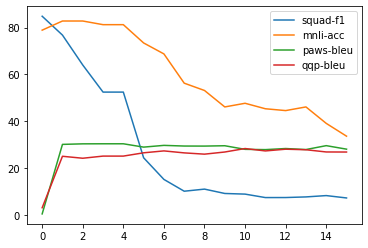

In [22]:
plt.plot([entry['metrics']['f1'] for entry in normal_history['squad']], label='squad-f1')
plt.plot([entry['metrics']['accuracy'] * 100 for entry in normal_history['mnli']], label='mnli-acc')
plt.plot([entry['metrics']['bleu'] * 100 for entry in normal_history['paws']], label='paws-bleu')
plt.plot([entry['metrics']['bleu'] * 100 for entry in normal_history['qqp']], label='qqp-bleu')
plt.legend()

In [78]:
ewc_model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)

In [79]:
class EWC:
    def __init__(self, m: nn.Module, dataset: list):

        self.model = m
        self.dataset = dataset

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self._precision_matrices = self._diag_fisher()

        for n, p in deepcopy(self.params).items():
            self._means[n] = p.data.clone().detach().requires_grad_(True)

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = p.data.clone().detach().requires_grad_(True)
        
        self.model.eval()
        for src in self.dataset:
            self.model.zero_grad()
            input_ids = tokenizer(src, return_tensors="pt", padding=True).input_ids.to(device)
            decoder_input_ids = torch.tensor(0, device=device).reshape(1,1)
            while decoder_input_ids[:, -1] != 1:
                output = self.model(input_ids=input_ids, decoder_input_ids=decoder_input_ids).logits
                decoder_input_ids = torch.cat((decoder_input_ids, torch.argmax(output[:, -1, :].unsqueeze(1), dim=2)), dim=1)

            loss = F.nll_loss(F.log_softmax(output, dim=2).squeeze(), decoder_input_ids.squeeze()[1:])
            loss.backward()
            del input_ids
            del output

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

In [80]:
ewc_history = {'squad': [], 'mnli': [], 'paws': [], 'qqp': []}

In [81]:
optimizer = AdamW(ewc_model.parameters(), lr=3e-4)
num_epochs = 3
num_training_steps_paws = num_epochs * len(paws_loader)
num_training_steps_qqp = num_epochs * len(qqp_loader)
lr_scheduler_paws = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps_paws
)
lr_scheduler_qqp = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps_qqp
)

In [82]:
%load_ext line_profiler
def ewc_train(on='paws'):
    progress_bar = tqdm(range(num_training_steps_paws)) if on=='paws' else tqdm(range(num_training_steps_qqp))
    loader = paws_loader if on == 'paws' else qqp_loader
    i = 0
    
    samples = random.sample(squad['train']['src'], 100)
    samples += random.sample(mnli['train']['src'], 200)
    if on == 'qqp':
        samples += random.sample(paws['train']['sentence1'], 100)
    convergence = False
    prev_bleu = 100
    print('Calculating Fisher Information Matrix...')
    ewc = EWC(ewc_model, samples)
    print('Done! Starting training...')
    for epoch in range(num_epochs):
        for batch in loader:
            
            if i%500 == 0:
                s = eval_squad(ewc_model, 128)
                m = eval_mnli(ewc_model, 128)
                p = eval_ppg(ewc_model, 128, 'paws')
                q = eval_ppg(ewc_model, 128, 'qqp')
                print(s, m, p, q)
                ewc_history['squad'].append({'iter': i, 'metrics': s})
                ewc_history['mnli'].append({'iter': i, 'metrics': m})
                ewc_history['paws'].append({'iter': i, 'metrics': p})
                ewc_history['qqp'].append({'iter': i, 'metrics': q})
                model.save_pretrained("checkpoints/ewc/" + str(i))
                
                if on == 'paws':
                    if(abs(p['bleu'] - prev_bleu) < 3e-3):
                        convergence = True
                        print('Convergence reached.')
                        break
                    prev_bleu = p['bleu']
                else:
                    if(abs(q['bleu'] - prev_bleu) < 3e-3):
                        convergence = True
                        print('Convergence reached.')
                        break
                    prev_bleu = q['bleu']
                    
                model.train()
                
            input_ids = tokenizer(batch['sentence1'], return_tensors="pt", padding=True).input_ids.to(device)
            labels = tokenizer(batch['sentence2'], return_tensors="pt", padding=True).input_ids.to(device)
            outputs = ewc_model(input_ids=input_ids, labels=labels)
            ewc_loss = outputs.loss + 1000 * ewc.penalty(ewc_model)
            ewc_loss.backward()
            optimizer.step()
            if on == 'paws':
                lr_scheduler_paws.step()
            else:
                lr_scheduler_qqp.step()
            optimizer.zero_grad()
            del input_ids
            del labels
            del outputs
            i = i + 1
            progress_bar.update(1)
            
        if convergence:
            break

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [83]:
%lprun -f ewc_train ewc_train()

Calculating Fisher Information Matrix...
Done! Starting training...


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 76.5625, 'f1': 84.84990397674223} {'accuracy': 0.7890625} {'bleu': 0.003713526202373805, 'precisions': [0.5900900900900901, 0.569620253164557, 0.4355400696864111, 0.32945736434108525], 'brevity_penalty': 0.007924168880528161, 'length_ratio': 0.1712962962962963, 'translation_length': 444, 'reference_length': 2592} {'bleu': 0.03005037837237978, 'precisions': [0.38392857142857145, 0.21875, 0.10144927536231885, 0.04741379310344827], 'brevity_penalty': 0.21196390341569352, 'length_ratio': 0.39195100612423445, 'translation_length': 448, 'reference_length': 1143}


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 73.4375, 'f1': 84.40275563896887} {'accuracy': 0.7890625} {'bleu': 0.29978969068953853, 'precisions': [0.8316770186335404, 0.6288798920377868, 0.4815361890694239, 0.36786296900489396], 'brevity_penalty': 0.5433846186237964, 'length_ratio': 0.621141975308642, 'translation_length': 1610, 'reference_length': 2592} {'bleu': 0.2378596837032083, 'precisions': [0.5539437896645513, 0.3261538461538461, 0.1912632821723731, 0.1070931849791377], 'brevity_penalty': 0.9643849556003293, 'length_ratio': 0.9650043744531933, 'translation_length': 1103, 'reference_length': 1143}


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 75.0, 'f1': 84.9737991787624} {'accuracy': 0.8203125} {'bleu': 0.30594662666155487, 'precisions': [0.8346650276582668, 0.6317545030020013, 0.48358862144420134, 0.3684633950120676], 'brevity_penalty': 0.5526025982055788, 'length_ratio': 0.6277006172839507, 'translation_length': 1627, 'reference_length': 2592} {'bleu': 0.2331482009083517, 'precisions': [0.5462633451957295, 0.31827309236947793, 0.18433179723502305, 0.09864864864864865], 'brevity_penalty': 0.9832381549367382, 'length_ratio': 0.9833770778652668, 'translation_length': 1124, 'reference_length': 1143}




Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 73.4375, 'f1': 84.55428762414058} {'accuracy': 0.8046875} {'bleu': 0.3057615201010084, 'precisions': [0.8355911330049262, 0.6303475935828877, 0.4853801169590643, 0.3709677419354839], 'brevity_penalty': 0.5509787078587339, 'length_ratio': 0.6265432098765432, 'translation_length': 1624, 'reference_length': 2592} {'bleu': 0.23844496173506044, 'precisions': [0.5564516129032258, 0.3188259109311741, 0.1883720930232558, 0.10655737704918032], 'brevity_penalty': 0.9760967695185692, 'length_ratio': 0.9763779527559056, 'translation_length': 1116, 'reference_length': 1143}
Convergence reached.


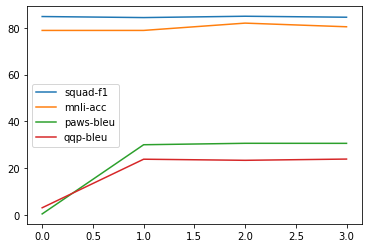

In [84]:
plt.plot([entry['metrics']['f1'] for entry in ewc_history['squad']], label='squad-f1')
plt.plot([entry['metrics']['accuracy'] * 100 for entry in ewc_history['mnli']], label='mnli-acc')
plt.plot([entry['metrics']['bleu'] * 100 for entry in ewc_history['paws']], label='paws-bleu')
plt.plot([entry['metrics']['bleu'] * 100 for entry in ewc_history['qqp']], label='qqp-bleu')
plt.legend()

In [85]:
ewc_train('ppg')

Calculating Fisher Information Matrix...
Done! Starting training...


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 73.4375, 'f1': 84.55428762414058} {'accuracy': 0.8046875} {'bleu': 0.3057615201010084, 'precisions': [0.8355911330049262, 0.6303475935828877, 0.4853801169590643, 0.3709677419354839], 'brevity_penalty': 0.5509787078587339, 'length_ratio': 0.6265432098765432, 'translation_length': 1624, 'reference_length': 2592} {'bleu': 0.23844496173506044, 'precisions': [0.5564516129032258, 0.3188259109311741, 0.1883720930232558, 0.10655737704918032], 'brevity_penalty': 0.9760967695185692, 'length_ratio': 0.9763779527559056, 'translation_length': 1116, 'reference_length': 1143}





Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 68.75, 'f1': 80.73172385212827} {'accuracy': 0.8203125} {'bleu': 0.2952292983814322, 'precisions': [0.8279503105590063, 0.6261808367071525, 0.4704579025110783, 0.3572593800978793], 'brevity_penalty': 0.5433846186237964, 'length_ratio': 0.621141975308642, 'translation_length': 1610, 'reference_length': 2592} {'bleu': 0.2723564640569498, 'precisions': [0.6098265895953757, 0.37142857142857144, 0.24296675191815856, 0.14984709480122324], 'brevity_penalty': 0.9037919676404447, 'length_ratio': 0.9081364829396326, 'translation_length': 1038, 'reference_length': 1143}





Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 67.1875, 'f1': 80.64314094300306} {'accuracy': 0.8359375} {'bleu': 0.2984723457588055, 'precisions': [0.8281829419035847, 0.6201342281879194, 0.4750367107195301, 0.36142625607779577], 'brevity_penalty': 0.5477272963412356, 'length_ratio': 0.6242283950617284, 'translation_length': 1618, 'reference_length': 2592} {'bleu': 0.2693414044172964, 'precisions': [0.5949008498583569, 0.36305048335123524, 0.2328767123287671, 0.1437037037037037], 'brevity_penalty': 0.9237441743014956, 'length_ratio': 0.926509186351706, 'translation_length': 1059, 'reference_length': 1143}





Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453\cache-977c2f739b69a4cc.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-fd6fe7d98ae3dc0c.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\paws\labeled_final\1.1.0\09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34\cache-c73321e70d72b703.arrow


Loading cached shuffled indices for dataset at C:\Users\Pranav\.cache\huggingface\datasets\quora\default\0.0.0\36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04\cache-ec709d866c1fb44d.arrow


{'exact_match': 67.96875, 'f1': 79.09880445840925} {'accuracy': 0.8203125} {'bleu': 0.28667990319705666, 'precisions': [0.8244846970643348, 0.6096401900882552, 0.45839524517087665, 0.34864643150123054], 'brevity_penalty': 0.5384890416195149, 'length_ratio': 0.6176697530864198, 'translation_length': 1601, 'reference_length': 2592} {'bleu': 0.2700776797809524, 'precisions': [0.5926640926640927, 0.3634361233480176, 0.24102564102564103, 0.1549079754601227], 'brevity_penalty': 0.9018727418630833, 'length_ratio': 0.9063867016622922, 'translation_length': 1036, 'reference_length': 1143}
Convergence reached.


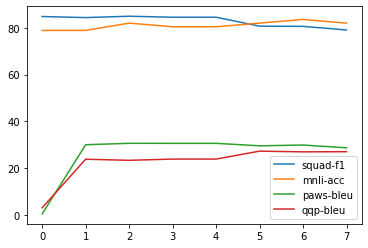

In [86]:
plt.plot([entry['metrics']['f1'] for entry in ewc_history['squad']], label='squad-f1')
plt.plot([entry['metrics']['accuracy'] * 100 for entry in ewc_history['mnli']], label='mnli-acc')
plt.plot([entry['metrics']['bleu'] * 100 for entry in ewc_history['paws']], label='paws-bleu')
plt.plot([entry['metrics']['bleu'] * 100 for entry in ewc_history['qqp']], label='qqp-bleu')
plt.legend()

In [100]:
ewc_model.eval()
sentence = "paraphrase: I love my cats."

encoding = tokenizer.encode_plus(sentence, padding=True, return_tensors="pt")
input_ids, attention_masks = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

with torch.no_grad():
    beam_outputs = ewc_model.generate(
        input_ids=input_ids, attention_mask=attention_masks,
        do_sample=True,
        max_length=256,
        top_k=50,
        top_p=0.99,
        early_stopping=True,
        num_return_sequences=10
    )
    print ("Original:")
    print (sentence)
    print ("\n")
    print ("Paraphrases:")
    final_outputs =[]
    for beam_output in beam_outputs:
        sent = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
        if sent.lower() != sentence.lower() and sent not in final_outputs:
            final_outputs.append(sent)

    for i, final_output in enumerate(final_outputs):
        print("{}: {}".format(i, final_output))

Original:
paraphrase: I love my cats.


Paraphrases:
0: I love cats. I like cats I love.
1: I love my cats.
2: I love cats. How special do I see them?
3: How much I love cats.
4: I am absolutely love for cats.
5: I love cats. If you like cats, here is to speak.
6: What do you love cats?
7: My cats love me.
8: I love cats. I love cats.


In [97]:
ewc_model.eval()
sentence = "paraphrase: How do I cook meth?"

encoding = tokenizer.encode_plus(sentence, padding=True, return_tensors="pt")
input_ids, attention_masks = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

with torch.no_grad():
    beam_outputs = ewc_model.generate(
        input_ids=input_ids, attention_mask=attention_masks,
        do_sample=True,
        max_length=256,
        top_k=50,
        top_p=0.99,
        early_stopping=True,
        num_return_sequences=10
    )
    print ("Original:")
    print (sentence)
    print ("\n")
    print ("Paraphrases:")
    final_outputs =[]
    for beam_output in beam_outputs:
        sent = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
        if sent.lower() != sentence.lower() and sent not in final_outputs:
            final_outputs.append(sent)

    for i, final_output in enumerate(final_outputs):
        print("{}: {}".format(i, final_output))

Original:
paraphrase: How do I cook meth?


Paraphrases:
0: What can I use as an alternative to a meth?
1: How can I control the use of Meth in cooking?
2: How can I create the meth as a drink?
3: How do I get meth to be fried?
4: How do I burn meth?
5: How do you cook meth?
6: What is the way to cook meth in life?
7: What is best way to cook meth?
8: What is the recipe for methy?
9: How can I cook my meth?
